# Letter Recognition Using SVM


## Data Understanding 

understanding the shape, attributes etc. of the dataset.

In [1]:
# libraries
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale

# dataset
letters = pd.read_csv("letter-recognition.csv")

### Dataset Understanding

It contains the 26 English alphabets as classes, so it's a multiclass classification problem with 26 classes.

Each row in the data set represents an image of a handwritten alphabet. Using some basic image processing, the images are converted into m X n pixels, where m and n depend on the size and resolution of the original image. Each pixel contains numeric values, with higher values denoting the presence of dense 'ink'. In the pixels where nothing is written, the pixel value is 0.

A pixel is called 'on' if it contains to a positive numeric value, else it is called 'off'.

Using the pixelated images, 16 features are derived for each image, such as the width of the box, the ratio of the mean variance of x divided by the width of the box, etc.

Attribute Information:

1. lettr capital letter (26 values from A to Z)
2. x-box horizontal position of box (integer)
3. y-box vertical position of box (integer)
4. width width of box (integer)
5. high height of box (integer)
6. onpix total # on pixels (integer)
7. x-bar mean x of on pixels in box (integer)
8. y-bar mean y of on pixels in box (integer)
9. x2bar mean x variance (integer)
10. y2bar mean y variance (integer)
11. xybar mean x y correlation (integer)
12. x2ybr mean of x * x * y (integer)
13. xy2br mean of x * y * y (integer)
14. x-ege mean edge count left to right (integer)
15. xegvy correlation of x-ege with y (integer)
16. y-ege mean edge count bottom to top (integer)
17. yegvx correlation of y-ege with x (integer)

In [2]:
# about the dataset

# dimensions
print("Dimensions: ", letters.shape, "\n")

# data types
print(letters.info())

# head
letters.head()

Dimensions:  (20000, 17) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   letter  20000 non-null  object
 1   xbox    20000 non-null  int64 
 2   ybox    20000 non-null  int64 
 3   width   20000 non-null  int64 
 4   height  20000 non-null  int64 
 5   onpix   20000 non-null  int64 
 6   xbar    20000 non-null  int64 
 7   ybar    20000 non-null  int64 
 8   x2bar   20000 non-null  int64 
 9   y2bar   20000 non-null  int64 
 10  xybar   20000 non-null  int64 
 11  x2ybar  20000 non-null  int64 
 12  xy2bar  20000 non-null  int64 
 13  xedge   20000 non-null  int64 
 14  xedgey  20000 non-null  int64 
 15  yedge   20000 non-null  int64 
 16  yedgex  20000 non-null  int64 
dtypes: int64(16), object(1)
memory usage: 2.6+ MB
None


,letter,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [3]:
# a quirky bug: the column names have a space, e.g. 'xbox ', which throws error when indexed
print(letters.columns)


Index(['letter', 'xbox ', 'ybox ', 'width ', 'height', 'onpix ', 'xbar ',
       'ybar ', 'x2bar', 'y2bar ', 'xybar ', 'x2ybar', 'xy2bar', 'xedge ',
       'xedgey', 'yedge ', 'yedgex'],
      dtype='object')


In [4]:
# let's 'reindex' the column names
letters.columns = ['letter', 'xbox', 'ybox', 'width', 'height', 'onpix', 'xbar',
       'ybar', 'x2bar', 'y2bar', 'xybar', 'x2ybar', 'xy2bar', 'xedge',
       'xedgey', 'yedge', 'yedgex']
print(letters.columns)

Index(['letter', 'xbox', 'ybox', 'width', 'height', 'onpix', 'xbar', 'ybar',
       'x2bar', 'y2bar', 'xybar', 'x2ybar', 'xy2bar', 'xedge', 'xedgey',
       'yedge', 'yedgex'],
      dtype='object')


In [5]:
order = list(np.sort(letters['letter'].unique()))
print(order)


['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


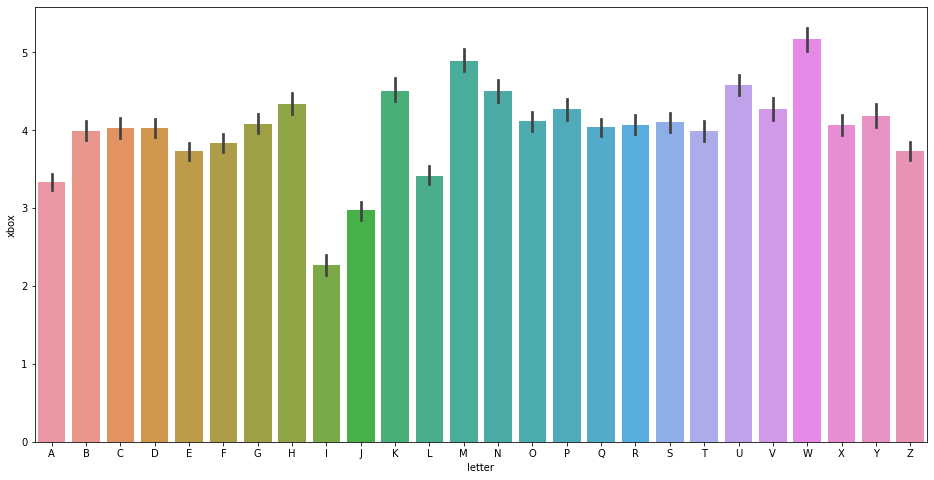

In [6]:
# basic plots: How various attributes vary with the letters

plt.figure(figsize=(16, 8))
sns.barplot(x='letter', y='xbox', 
            data=letters, 
            order=order)

In [7]:
letter_means = letters.groupby('letter').mean()
letter_means.head()

,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
letter,,,,,,,,,,,,,,,,
A,3.337136,6.975919,5.128010,5.178707,2.991128,8.851711,3.631179,2.755387,2.043093,7.802281,2.338403,8.465146,2.771863,6.321926,2.875792,7.468948
B,3.985640,6.962141,5.088773,5.169713,4.596606,7.671018,7.062663,5.366841,5.571802,7.954308,5.506527,6.652742,3.117493,7.919060,6.612272,9.100522
C,4.031250,7.063859,4.701087,5.296196,2.775815,5.437500,7.627717,5.927989,7.177989,8.773098,7.494565,11.947011,1.991848,8.876359,4.080163,8.555707
D,4.023602,7.244720,5.170186,5.288199,4.026087,7.539130,6.806211,5.921739,6.508075,8.166460,5.111801,5.750311,3.365217,7.813665,3.971429,7.628571
E,3.727865,6.944010,4.756510,5.201823,3.679688,5.966146,7.352865,4.223958,7.585938,8.507812,6.242188,10.341146,2.127604,8.298177,6.022135,8.506510


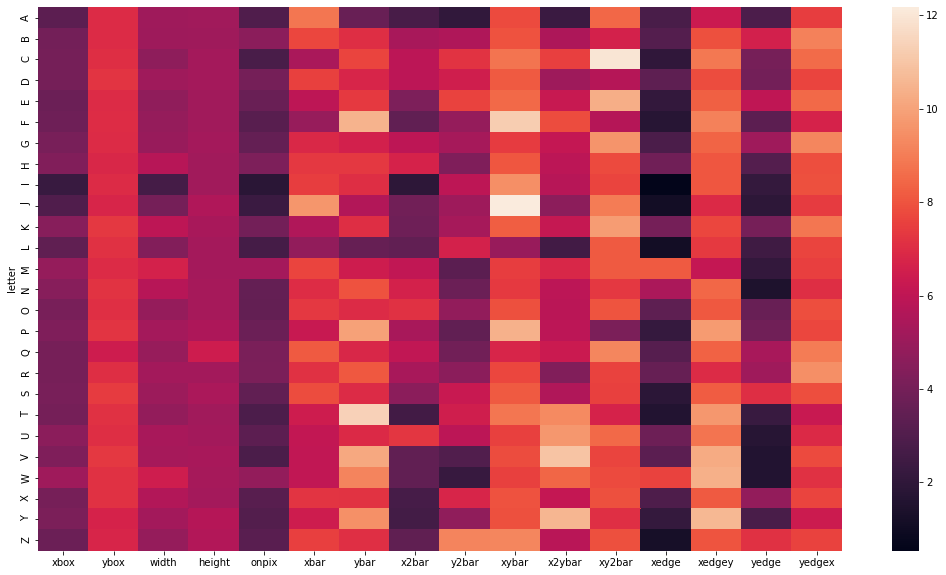

In [8]:
# Heatmap for means
plt.figure(figsize=(18, 10))
sns.heatmap(letter_means)

## Data Preparation


In [9]:
# average feature values
round(letters.drop('letter', axis=1).mean(), 2)

xbox      4.02
ybox      7.04
width     5.12
height    5.37
onpix     3.51
xbar      6.90
ybar      7.50
x2bar     4.63
y2bar     5.18
xybar     8.28
x2ybar    6.45
xy2bar    7.93
xedge     3.05
xedgey    8.34
yedge     3.69
yedgex    7.80
dtype: float64

In [10]:
# splitting into X and y
X = letters.drop("letter", axis = 1)
y = letters['letter']

In [11]:
# scaling the features
X_scaled = scale(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 101)

## Model Building

Two basic models - linear and non-linear with default hyperparameters, and compare the accuracies.

In [12]:
# linear model

model_linear = SVC(kernel='linear')
model_linear.fit(X_train, y_train)

# predict
y_pred = model_linear.predict(X_test)


In [13]:
# confusion matrix and accuracy

# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")

# cm
matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))

accuracy: 0.8523333333333334 

[[198   0   0   0   0   0   1   1   0   1   1   1   0   0   0   0   0   1
    0   1   1   0   0   0   3   0]
 [  0 188   0   3   0   1   3   3   1   0   1   0   0   2   0   1   1   9
    3   0   0   1   0   1   0   0]
 [  1   0 200   0   7   0  12   1   0   0   5   0   0   0   3   0   0   0
    0   0   1   0   0   0   0   0]
 [  1  15   0 210   0   1   2   2   1   0   1   0   1   5   3   0   0   5
    0   1   0   0   0   0   0   0]
 [  0   1   3   0 204   2   6   1   0   0   1   5   0   0   0   0   2   2
    1   2   0   0   0   1   0   3]
 [  0   0   0   1   1 201   1   2   1   1   0   0   0   2   0   2   0   0
    3   7   1   0   1   0   1   0]
 [  0   1   9   4   2   2 167   1   0   1   4   3   1   0   1   0   9   1
    8   0   0   2   3   0   0   0]
 [  0   7   3  11   0   4   3 141   0   2   4   1   2   0  12   0   4  12
    0   0   4   2   0   4   1   0]
 [  0   0   2   3   0   6   0   0 184   9   0   0   0   0   1   0   0   0
    3   0   0   0   0  

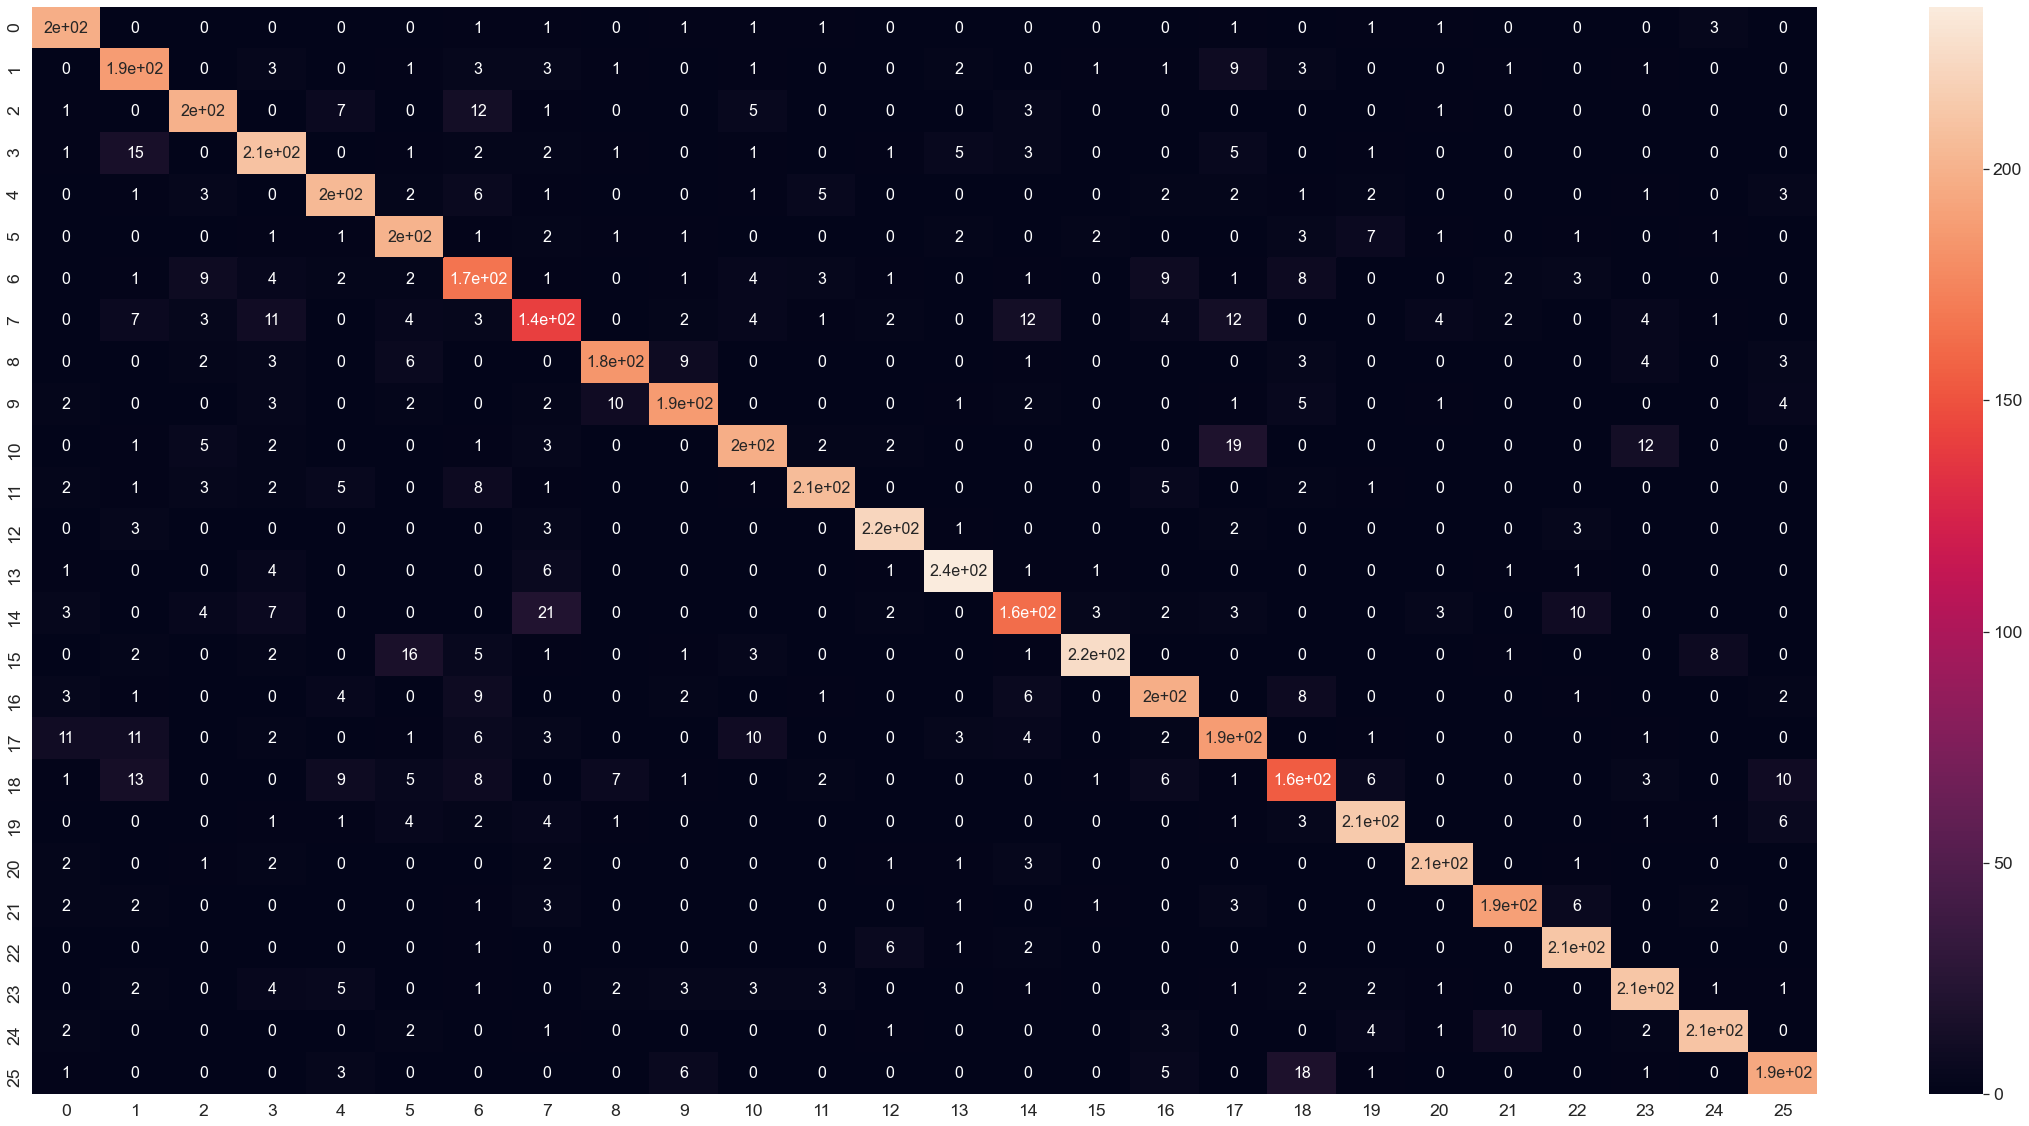

In [14]:
# heat map for confusion matrix
lr = pd.DataFrame(matrix)
plt.figure(figsize=(40,20))
sns.set(font_scale=1.6) # for label size
sns.heatmap(lr, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [15]:
# precision and recall
print(metrics.classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           A      0.861     0.947     0.902       209
           B      0.758     0.862     0.807       218
           C      0.870     0.870     0.870       230
           D      0.805     0.847     0.825       248
           E      0.846     0.872     0.859       234
           F      0.814     0.893     0.852       225
           G      0.705     0.763     0.732       219
           H      0.698     0.650     0.673       217
           I      0.889     0.856     0.872       215
           J      0.874     0.850     0.862       220
           K      0.853     0.808     0.830       245
           L      0.920     0.869     0.894       237
           M      0.929     0.949     0.939       234
           N      0.933     0.936     0.934       251
           O      0.803     0.738     0.769       221
           P      0.962     0.849     0.902       265
           Q      0.835     0.843     0.839       235
           R      0.755    

The linear model gives approx. 85% accuracy. Let's look at a sufficiently non-linear model with randomly chosen hyperparameters.

In [16]:
# non-linear model
# using rbf kernel, C=1, default value of gamma

# model
non_linear_model = SVC(kernel='rbf')

# fit
non_linear_model.fit(X_train, y_train)

# predict
y_pred = non_linear_model.predict(X_test)

In [17]:
# confusion matrix and accuracy

# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")

# cm
matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))

accuracy: 0.9383333333333334 

[[205   0   0   1   0   0   0   0   0   1   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   2   0]
 [  0 205   0   3   1   0   1   0   0   0   0   0   0   0   0   0   0   6
    1   0   0   0   0   1   0   0]
 [  0   0 213   0   5   0   7   1   0   0   0   0   0   0   4   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   4   0 234   0   0   1   3   0   0   0   0   0   3   1   0   0   2
    0   0   0   0   0   0   0   0]
 [  0   0   0   0 221   1   9   0   0   0   0   0   0   0   0   0   0   1
    0   0   0   0   0   0   0   2]
 [  0   0   0   1   0 215   1   1   1   0   0   0   0   1   0   1   0   0
    1   3   0   0   0   0   0   0]
 [  0   0   3   4   1   1 202   0   0   0   0   1   1   0   2   0   0   1
    0   0   0   1   2   0   0   0]
 [  0   7   0   5   0   0   4 177   0   0   2   0   1   0   3   0   4  13
    0   0   1   0   0   0   0   0]
 [  0   0   1   1   0   3   0   0 194  11   0   0   0   0   0   1   0   0
    2   0   0   0   0  

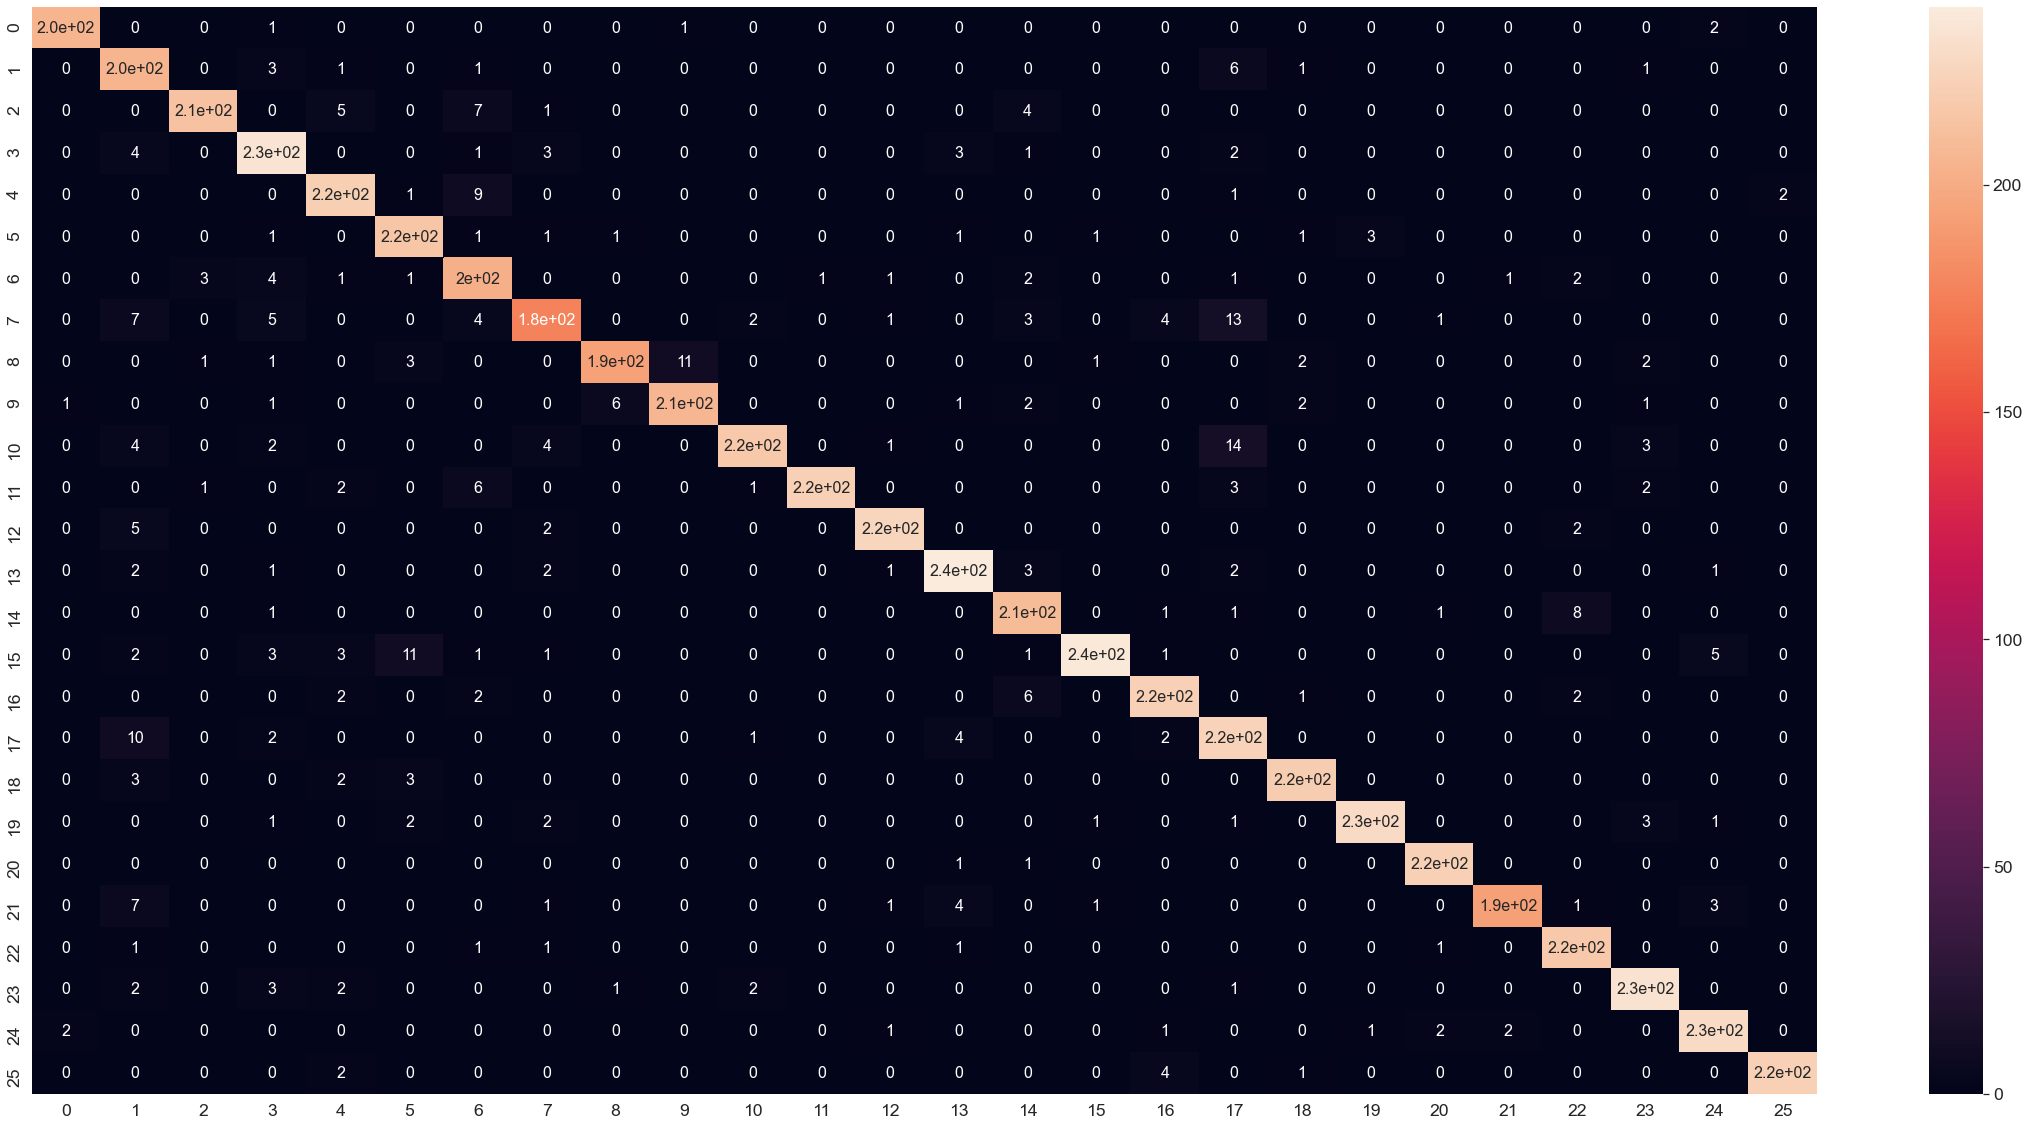

In [18]:
# heat map for confusion matrix
lr = pd.DataFrame(matrix)
plt.figure(figsize=(40,20))
sns.set(font_scale=1.6) # for label size
sns.heatmap(lr, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [19]:
# precision and recall
print(metrics.classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           A      0.986     0.981     0.983       209
           B      0.813     0.940     0.872       218
           C      0.977     0.926     0.951       230
           D      0.890     0.944     0.916       248
           E      0.917     0.944     0.931       234
           F      0.911     0.956     0.933       225
           G      0.860     0.922     0.890       219
           H      0.908     0.816     0.859       217
           I      0.960     0.902     0.930       215
           J      0.945     0.936     0.941       220
           K      0.973     0.886     0.927       245
           L      0.996     0.937     0.965       237
           M      0.974     0.962     0.968       234
           N      0.941     0.952     0.947       251
           O      0.901     0.946     0.923       221
           P      0.983     0.894     0.937       265
           Q      0.945     0.945     0.945       235
           R      0.833    

The non-linear model gives approx. 93% accuracy. Thus, going forward, we choose hyperparameters corresponding to non-linear models.

## Grid Search: Hyperparameter Tuning

Tuning the model to find the optimal values of C and gamma corresponding to an RBF kernel. using 5-fold cross validation.

In [20]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 101)

# range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [1e-2, 1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]


# model
model = SVC(kernel="rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 11.0min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=101, shuffle=True),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.01, 0.001, 0.0001]}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [21]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.918883,0.025246,1.513671,0.007735,1,0.01,"{'C': 1, 'gamma': 0.01}",0.826429,0.834643,0.828571,...,0.832714,0.006221,7,0.843929,0.844196,0.847679,0.843571,0.844018,0.844679,0.001514
1,6.193002,0.041353,1.943975,0.013020,1,0.001,"{'C': 1, 'gamma': 0.001}",0.684643,0.672500,0.682500,...,0.677214,0.005622,10,0.682054,0.683125,0.687946,0.679554,0.686429,0.683821,0.003021
2,12.089198,0.576465,2.140524,0.145152,1,0.0001,"{'C': 1, 'gamma': 0.0001}",0.203929,0.207143,0.206429,...,0.217571,0.014490,12,0.212679,0.217589,0.228393,0.240625,0.240625,0.227982,0.011507
3,2.160339,0.112966,1.238882,0.073883,10,0.01,"{'C': 10, 'gamma': 0.01}",0.914643,0.908571,0.902500,...,0.911214,0.005654,3,0.929643,0.929464,0.930357,0.928929,0.928125,0.929304,0.000746
4,3.529311,0.212988,1.839109,0.065364,10,0.001,"{'C': 10, 'gamma': 0.001}",0.805714,0.809643,0.803571,...,0.808929,0.006227,8,0.818125,0.817679,0.819643,0.814375,0.819464,0.817857,0.001897
5,7.426685,0.620354,2.466559,0.291473,10,0.0001,"{'C': 10, 'gamma': 0.0001}",0.684286,0.671071,0.682500,...,0.677000,0.005788,11,0.681875,0.683304,0.687500,0.680089,0.685446,0.683643,0.002608
6,1.974402,0.012646,0.716505,0.005330,100,0.01,"{'C': 100, 'gamma': 0.01}",0.948571,0.946786,0.941429,...,0.947786,0.003742,2,0.978482,0.977946,0.978393,0.978661,0.978571,0.978411,0.000249
7,2.057459,0.015424,1.044341,0.007513,100,0.001,"{'C': 100, 'gamma': 0.001}",0.861071,0.866071,0.850357,...,0.863357,0.008074,5,0.879554,0.877143,0.882143,0.875536,0.879464,0.878768,0.002262
8,2.987732,0.098144,1.717568,0.233050,100,0.0001,"{'C': 100, 'gamma': 0.0001}",0.801071,0.806429,0.803929,...,0.805714,0.006140,9,0.813571,0.812679,0.814286,0.810000,0.815357,0.813179,0.001815
9,2.233469,0.085839,0.649766,0.010881,1000,0.01,"{'C': 1000, 'gamma': 0.01}",0.953571,0.949643,0.948571,...,0.951714,0.002183,1,0.997054,0.997768,0.997411,0.997321,0.997232,0.997357,0.000237


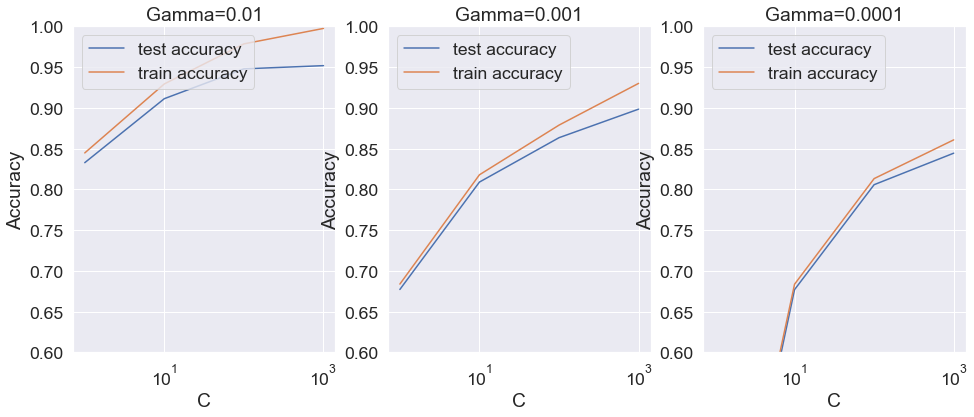

In [22]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


The plots above show some useful insights:
- Non-linear models (high gamma) perform *much better* than the linear ones
- At any value of gamma, a high value of C leads to better performance
- None of the models tend to overfit (even the complex ones), since the training and test accuracies closely follow each other

This suggests that the problem and the data is **inherently non-linear** in nature, and a complex model will outperform simple, linear models in this case.

Let's now choose the best hyperparameters. 

In [23]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.9517142857142857 corresponding to hyperparameters {'C': 1000, 'gamma': 0.01}


### Building and Evaluating the Final Model

Let's now build and evaluate the final model, i.e. the model with highest test accuracy.

In [24]:
# model with optimal hyperparameters

# model
model = SVC(C=1000, gamma=0.01, kernel="rbf")

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# metrics
print("accuracy", metrics.accuracy_score(y_test, y_pred), "\n")
matrix = metrics.confusion_matrix(y_test, y_pred), "\n"
print(metrics.confusion_matrix(y_test, y_pred), "\n")

accuracy 0.9596666666666667 

[[206   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
    0   0   0   0   0   0   2   0]
 [  0 211   0   2   1   0   1   0   0   0   0   0   0   0   0   0   0   1
    2   0   0   0   0   0   0   0]
 [  0   0 220   0   3   0   4   1   0   0   0   0   0   0   2   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   3   0 236   0   1   0   1   0   1   0   0   0   2   2   0   0   1
    1   0   0   0   0   0   0   0]
 [  0   0   1   0 225   1   4   0   0   0   0   0   0   0   0   0   0   0
    1   0   0   0   0   0   0   2]
 [  0   0   0   1   0 217   0   0   1   1   0   0   0   1   0   3   0   0
    0   0   0   1   0   0   0   0]
 [  0   0   2   3   1   0 209   0   0   0   0   0   1   0   1   0   0   0
    0   0   0   1   1   0   0   0]
 [  0   1   3   5   0   0   2 195   1   1   2   1   1   0   1   0   3   1
    0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   1   0   0 203   8   0   0   0   0   0   0   1   0
    0   0   0   0   0   

In [26]:
# precision and recall
print(metrics.classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           A      0.986     0.986     0.986       209
           B      0.906     0.968     0.936       218
           C      0.965     0.957     0.961       230
           D      0.929     0.952     0.940       248
           E      0.934     0.962     0.947       234
           F      0.939     0.964     0.952       225
           G      0.917     0.954     0.935       219
           H      0.929     0.899     0.913       217
           I      0.953     0.944     0.949       215
           J      0.941     0.950     0.946       220
           K      0.966     0.931     0.948       245
           L      0.987     0.979     0.983       237
           M      0.975     0.983     0.979       234
           N      0.957     0.972     0.964       251
           O      0.963     0.950     0.957       221
           P      0.969     0.951     0.960       265
           Q      0.962     0.962     0.962       235
           R      0.945    

## Conclusion

The accuracy achieved using a non-linear kernel (0.95) is much higher than that of a linear one (0.85). 

We can conclude that the problem is highly non-linear in nature.